In [1]:
import numpy as np
import jax
from jax import numpy as jnp
from jax import jit, vmap, grad
from jax import random
from IPython.display import Markdown
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

In [2]:
compound_embedding_path = "/content/drive/MyDrive/LangOn/semanticsNTU/tencent_compounds_embeddings.txt.gz"

In [3]:
import gzip
from tqdm.auto import tqdm
words = []
emb_data = []

with gzip.open(compound_embedding_path, "rt") as fin:
  n_vocab, n_hdim = fin.readline().split(" ")
  n_hdim = int(n_hdim)
  for i in tqdm(range(int(n_vocab))):
    toks = fin.readline().strip().split(" ")
    word = toks[0]
    emb = np.array([float(x) for x in toks[1:]])
    words.append(word)
    emb_data.append(emb)
emb_data = np.vstack(emb_data)

  0%|          | 0/119797 [00:00<?, ?it/s]

In [4]:
# center and normalize all vectors
norm_data = emb_data.copy()
norm_data = norm_data - norm_data.mean(axis=0)
norm_data = norm_data / np.linalg.norm(norm_data, axis=1)[:, np.newaxis]

In [5]:
dataset = []
counter = 0
word_map = {w: i for i, w in enumerate(words)}
for word, emb in zip(words, norm_data):
  if len(word) != 4: continue
  compound = word
  w1 = word[:2]
  w2 = word[2:]
  w1_vec = None
  w2_vec = None
  try:
    w1_vec = norm_data[word_map[w1]]
    w2_vec = norm_data[word_map[w2]]
  except KeyError:
    continue
  comp_vec = emb
  rank = counter
  counter += 1
  dataset.append({
      "rank": rank,
      "w1": w1, "w2": w2, "compound": compound,
      "w1_vec": w1_vec, "w2_vec": w2_vec,
      "comp_vec": comp_vec
  })

In [6]:
len(dataset)

75957

In [7]:
@jit
def find_closest(ref_mat, probe):
  return jnp.argmax(jnp.dot(ref_mat, probe))
vmap_find_closest = jit(vmap(find_closest, (None, 0), 0))

In [8]:
probe_vec = jnp.array(norm_data[6555])
find_closest(jnp.array(norm_data), probe_vec)

DeviceArray(6555, dtype=int32)

## Helper functions

$$
AX=B \\
X = (A^\top A)^{-1} A^\top B
$$

In [9]:
def get_train_test_split(dataset, train_offset, train_size, test_offset, test_size):
  train_ds = []
  test_ds = []
  to_idx = lambda x: int(len(dataset)*x)
  train_range = (to_idx(train_offset), to_idx(train_offset)+to_idx(train_size))
  test_range = (to_idx(test_offset), to_idx(test_offset)+to_idx(test_size))
  for idx, entry in enumerate(dataset):
    if train_range[0] < idx < train_range[1] \
       and idx % 10 > 1:
      train_ds.append(entry)
    elif test_range[0] < idx < test_range[1] \
       and idx % 10 <= 1:
      test_ds.append(entry)
  return train_ds, test_ds

def make_data_matrix(ds):
  A = np.vstack([np.hstack([x["w1_vec"], x["w2_vec"]]) for x in ds])
  B = np.vstack([x["comp_vec"] for x in ds])
  return A, B

def compute_X(A, B):
  AtA_inv = np.linalg.inv(np.dot(A.transpose(), A))
  trainX = np.dot(np.dot(AtA_inv, A.transpose()), B)
  return trainX

def pred_B(A, X):
  return np.dot(A, X)

def compute_accuracy(A, B, X, label=""):
  pred_idxs = []
  predB = pred_B(A, X)
  batch_size = 512
  for i in range(0, len(predB), batch_size):
    preds = vmap_find_closest(B, predB[i:i+batch_size])
    pred_idxs.extend(np.asarray(preds).tolist())
  n_correct = sum([x == i for i, x in enumerate(pred_idxs)])
  acc = n_correct/len(pred_idxs)  
  return acc

In [10]:
def run_condition(train_offset, train_size, test_offset, test_size):
  train_ds, test_ds = get_train_test_split(dataset, train_offset, train_size, test_offset, test_size)
  trainA, trainB = make_data_matrix(train_ds)
  testA, testB = make_data_matrix(test_ds)
  X_hat = compute_X(trainA, trainB)
  train_acc = compute_accuracy(trainA, trainB, X_hat, label="train")
  test_acc = compute_accuracy(testA, testB, X_hat, label="test")
  result = (f"| {train_offset*100:.0f}% | {train_size*100:.0f}%"
      f"| {test_offset*100:.0f}% | {test_size*100:.0f}%"
      f"| {len(train_ds)} | {len(test_ds)} | {train_acc:.2f} | {test_acc:.2f} |")
  return result

## Full Testing set

### Full testing, different training size

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., 0.3, 0., 1.),
    (0., 0.5, 0., 1.),
    (0., 1., 0., 1.),    
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/3 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 30%| 0% | 100%| 18229 | 15191 | 0.74 | 0.61 |
| 0% | 50%| 0% | 100%| 30382 | 15191 | 0.67 | 0.63 |
| 0% | 100%| 0% | 100%| 60765 | 15191 | 0.51 | 0.65 |

### Full testing, different 10% Training

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., 0.1, 0., 1.),
    (0.1, 0.1, 0., 1.),
    (0.3, 0.1, 0., 1.),
    (0.5, 0.1, 0., 1.),    
    (0.7, 0.1, 0., 1.)
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/5 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 10%| 0% | 100%| 6075 | 15191 | 0.83 | 0.57 |
| 10% | 10%| 0% | 100%| 6076 | 15191 | 0.90 | 0.60 |
| 30% | 10%| 0% | 100%| 6074 | 15191 | 0.90 | 0.63 |
| 50% | 10%| 0% | 100%| 6074 | 15191 | 0.90 | 0.63 |
| 70% | 10%| 0% | 100%| 6074 | 15191 | 0.88 | 0.64 |

### Full testing, different 20% Training

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., 0.2, 0., 1.),
    (0.1, 0.2, 0., 1.),
    (0.3, 0.2, 0., 1.),
    (0.5, 0.2, 0., 1.),    
    (0.7, 0.2, 0., 1.)
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/5 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 0% | 100%| 12152 | 15191 | 0.78 | 0.60 |
| 10% | 20%| 0% | 100%| 12152 | 15191 | 0.82 | 0.62 |
| 30% | 20%| 0% | 100%| 12152 | 15191 | 0.82 | 0.64 |
| 50% | 20%| 0% | 100%| 12152 | 15191 | 0.81 | 0.65 |
| 70% | 20%| 0% | 100%| 12152 | 15191 | 0.76 | 0.65 |

## Testing with a fixed 10%

### Testing the first 10% with different training set

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., .2, 0., .1),
    (0.3, .2, 0., .1),
    (0.5, .2, 0., .1),
    (0.7, .2, 0., .1),    
]
results = ["",
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/4 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 0% | 10%| 12152 | 1519 | 0.78 | 0.88 |
| 30% | 20%| 0% | 10%| 12152 | 1519 | 0.82 | 0.86 |
| 50% | 20%| 0% | 10%| 12152 | 1519 | 0.81 | 0.85 |
| 70% | 20%| 0% | 10%| 12152 | 1519 | 0.76 | 0.83 |

### Testing the last 10% with different training set

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., .2, 0.9, .1),
    (0.3, .2, 0.9, .1),
    (0.5, .2, 0.9, .1),
    (0.7, .2, 0.9, .1),    
]
results = [description, 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/4 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 90% | 10%| 12152 | 1518 | 0.78 | 0.70 |
| 30% | 20%| 90% | 10%| 12152 | 1518 | 0.82 | 0.73 |
| 50% | 20%| 90% | 10%| 12152 | 1518 | 0.81 | 0.74 |
| 70% | 20%| 90% | 10%| 12152 | 1518 | 0.76 | 0.74 |

## Testing with dataset of the same size, but of different slices

### Test different proportion with the first 20% training set

In [ ]:
description = ""
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., .2, 0.1, .1),
    (0., .2, 0.2, .1),
    (0., .2, 0.3, .1),
    (0., .2, 0.4, .1),
    (0., .2, 0.5, .1),
    (0., .2, 0.6, .1),
    (0., .2, 0.7, .1),
    (0., .2, 0.8, .1),    
    (0., .2, 0.9, .1),    
]
results = [description, 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/9 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 10% | 10%| 12152 | 1518 | 0.78 | 0.90 |
| 0% | 20%| 20% | 10%| 12152 | 1518 | 0.78 | 0.92 |
| 0% | 20%| 30% | 10%| 12152 | 1520 | 0.78 | 0.91 |
| 0% | 20%| 40% | 10%| 12152 | 1518 | 0.78 | 0.91 |
| 0% | 20%| 50% | 10%| 12152 | 1520 | 0.78 | 0.89 |
| 0% | 20%| 60% | 10%| 12152 | 1518 | 0.78 | 0.88 |
| 0% | 20%| 70% | 10%| 12152 | 1520 | 0.78 | 0.87 |
| 0% | 20%| 80% | 10%| 12152 | 1518 | 0.78 | 0.85 |
| 0% | 20%| 90% | 10%| 12152 | 1518 | 0.78 | 0.70 |

### Test different proportion with the last 20% training set

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (.8, .2, 0.1, .1),
    (.8, .2, 0.2, .1),
    (.8, .2, 0.3, .1),
    (.8, .2, 0.4, .1),
    (.8, .2, 0.5, .1),
    (.8, .2, 0.6, .1),
    (.8, .2, 0.7, .1),    
    (.8, .2, 0.8, .1),    
    (.8, .2, 0.9, .1),    
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/9 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 80% | 20%| 10% | 10%| 12152 | 1518 | 0.68 | 0.87 |
| 80% | 20%| 20% | 10%| 12152 | 1518 | 0.68 | 0.88 |
| 80% | 20%| 30% | 10%| 12152 | 1520 | 0.68 | 0.89 |
| 80% | 20%| 40% | 10%| 12152 | 1518 | 0.68 | 0.88 |
| 80% | 20%| 50% | 10%| 12152 | 1520 | 0.68 | 0.87 |
| 80% | 20%| 60% | 10%| 12152 | 1518 | 0.68 | 0.87 |
| 80% | 20%| 70% | 10%| 12152 | 1520 | 0.68 | 0.87 |
| 80% | 20%| 80% | 10%| 12152 | 1518 | 0.68 | 0.85 |
| 80% | 20%| 90% | 10%| 12152 | 1518 | 0.68 | 0.75 |

## Effect of training size

In [ ]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (.0, .1, 0.1, .2),        
    (.0, .2, 0.1, .2),        
    (.0, .3, 0.1, .2),        
    (.0, .4, 0.1, .2),        
    (.0, .6, 0.1, .2),        
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/5 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 10%| 10% | 20%| 6075 | 3038 | 0.83 | 0.85 |
| 0% | 20%| 10% | 20%| 12152 | 3038 | 0.78 | 0.87 |
| 0% | 30%| 10% | 20%| 18229 | 3038 | 0.74 | 0.87 |
| 0% | 40%| 10% | 20%| 24304 | 3038 | 0.70 | 0.87 |
| 0% | 60%| 10% | 20%| 36458 | 3038 | 0.65 | 0.87 |

## Eyeballing prediction errors

In [ ]:
def rank_predictions(ref_mat, probe):
  pred_idxs = jnp.argsort(-jnp.dot(ref_mat, probe))
  return pred_idxs[:10]
vmap_rank_predictions = jit(vmap(rank_predictions, (None, 0), 0))

In [ ]:
train_ds, test_ds = get_train_test_split(dataset, 0., .2, .1, .2)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)
B_hat = pred_B(testA, X_hat)

In [ ]:
predictions = []
batch_size = 256
for i in tqdm(range(0, B_hat.shape[0], batch_size)):
  preds_sorted = vmap_rank_predictions(testB, B_hat[i:i+batch_size])
  predictions.append(np.asarray(preds_sorted))
predictions = np.vstack(predictions)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
errors = []
for i in range(predictions.shape[0]):
  if predictions[i,0] == i: continue
  errors.append((
      test_ds[i]["compound"],
      [test_ds[pred_idx]["compound"] for pred_idx in predictions[i]]
  ))

In [ ]:
print(*[f"{x[0]}: {' '.join(x[1])}" for x in errors[-10:]], sep="\n")

黑暗组织: 极端分子 犯罪组织 政治组织 组织犯罪 专业组织 外国势力 学生组织 黑暗组织 西方势力 行动小组
营养午餐: 水果沙拉 营养午餐 健康零食 孕期营养 海鲜大餐 营养来源 饮食生活 身体能量 固体食物 饮食管理
环保检查: 环境检测 水质监测 环保检查 环境标准 环评报告 监测工作 工业废气 食品卫生 环境清洁 产品安全
观察名单: 参赛名单 中奖名单 评定结果 活动情况 观察记录 调查资料 监测结果 排名结果 观察名单 股东名单
计算单位: 委托单位 计算单位 上级单位 独立核算 单位管理 法人企业 单项工程 合作银行 生产部门 合同要求
混合结构: 组成结构 拓扑结构 电子结构 作用机理 排列方式 体积分数 形态结构 工艺条件 原子结构 混合结构
管理大师: 技术顾问 开发管理 管理大师 单位管理 研发管理 管理策略 管理知识 制度管理 维护人员 部门人员
剧本台词: 电影剧本 电影片段 情节设计 情节设置 剧本台词 电影角色 剧本创作 服装道具 男女主演 人物设计
政府事务: 政府行政 政府职能 政府管理 行政权力 政府事务 政治活动 国家机构 国家权力 国家政府 移民问题
华人文化: 语言文化 客家文化 音乐文化 华人文化 世界文明 文化魅力 文化研究 文化方面 主流文化 人文艺术


## Visualize Projection Matrix

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## First 20% of training data
```
Train Offset	Train Ratio	Test Offset	TestRatio	Train Size	Test Size	Train Acc	Test Acc
0%	20%	10%	20%	12152	3038	0.78	0.87
```

In [ ]:
train_ds, test_ds = get_train_test_split(dataset, 0., .2, .1, .2)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)

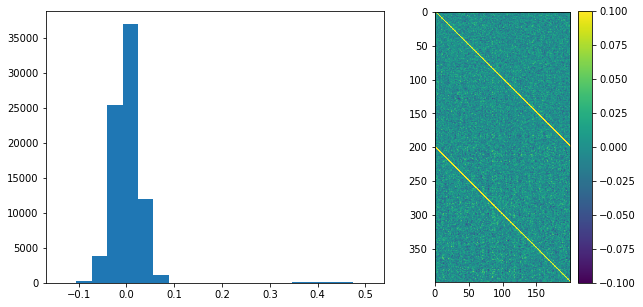

In [ ]:
plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
plt.subplot(gs[0])
plt.hist(X_hat.flatten(), bins=20)
plt.subplot(gs[1])
plt.imshow(X_hat, vmin=-0.1, vmax=0.1)
plt.colorbar()

## Full data

```
Train Offset	Train Ratio	Test Offset	TestRatio	Train Size	Test Size	Train Acc	Test Acc
0%	100%	0%	100%	60765	15191	0.51	0.65
```

In [ ]:
train_ds, test_ds = get_train_test_split(dataset, 0., 1., 0., 1.)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)

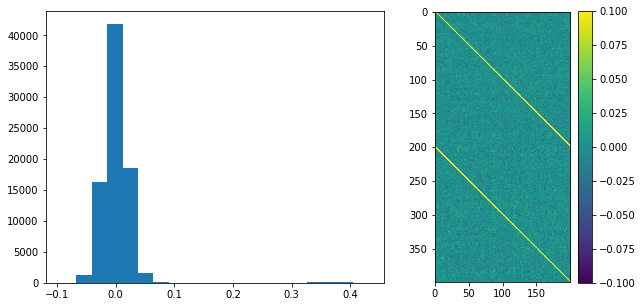

In [ ]:
plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
plt.subplot(gs[0])
plt.hist(X_hat.flatten(), bins=20)
plt.subplot(gs[1])
plt.imshow(X_hat, vmin=-0.1, vmax=0.1)
plt.colorbar()

In [15]:
train_ds, test_ds = get_train_test_split(dataset, 0.9, .1, 0.9, .1)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)

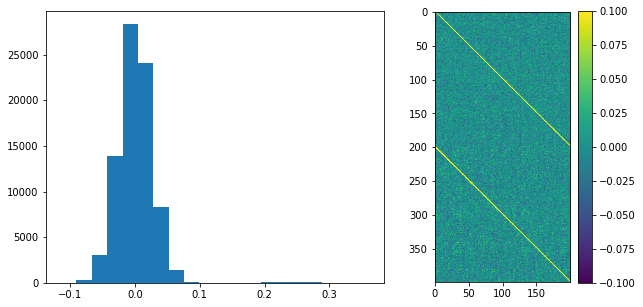

In [16]:
plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
plt.subplot(gs[0])
plt.hist(X_hat.flatten(), bins=20)
plt.subplot(gs[1])
plt.imshow(X_hat, vmin=-0.1, vmax=0.1)
plt.colorbar()